### **Unzipping dataset**

In [1]:
import zipfile
import os

with zipfile.ZipFile("/content/labels-20250212T103318Z-001.zip", "r") as zip_ref:
  zip_ref.extractall("/content/")

### **Data Exploration and Understanding**

In [2]:
label_count = []

for filename in os.listdir("/content/labels/labels_native"):
  file_path = os.path.join("/content/labels/labels_native", filename)

  with open(file_path, "r") as f:
    lines = [line for line in f.read().splitlines() if line.strip()]
    label_count.append(len(lines))

### **How many instances of solar panels are present in the dataset?**

In [3]:
s = 0
for i in label_count:
  s += i

print(f"No of images : {len(label_count)}")
print(f"No of instances of solar panels : {s}")

No of images : 2542
No of instances of solar panels : 29625


### **Compute and show the value counts of labels per image. E.g., X images have 0 labels, Y images have 1 label, … and so on.**

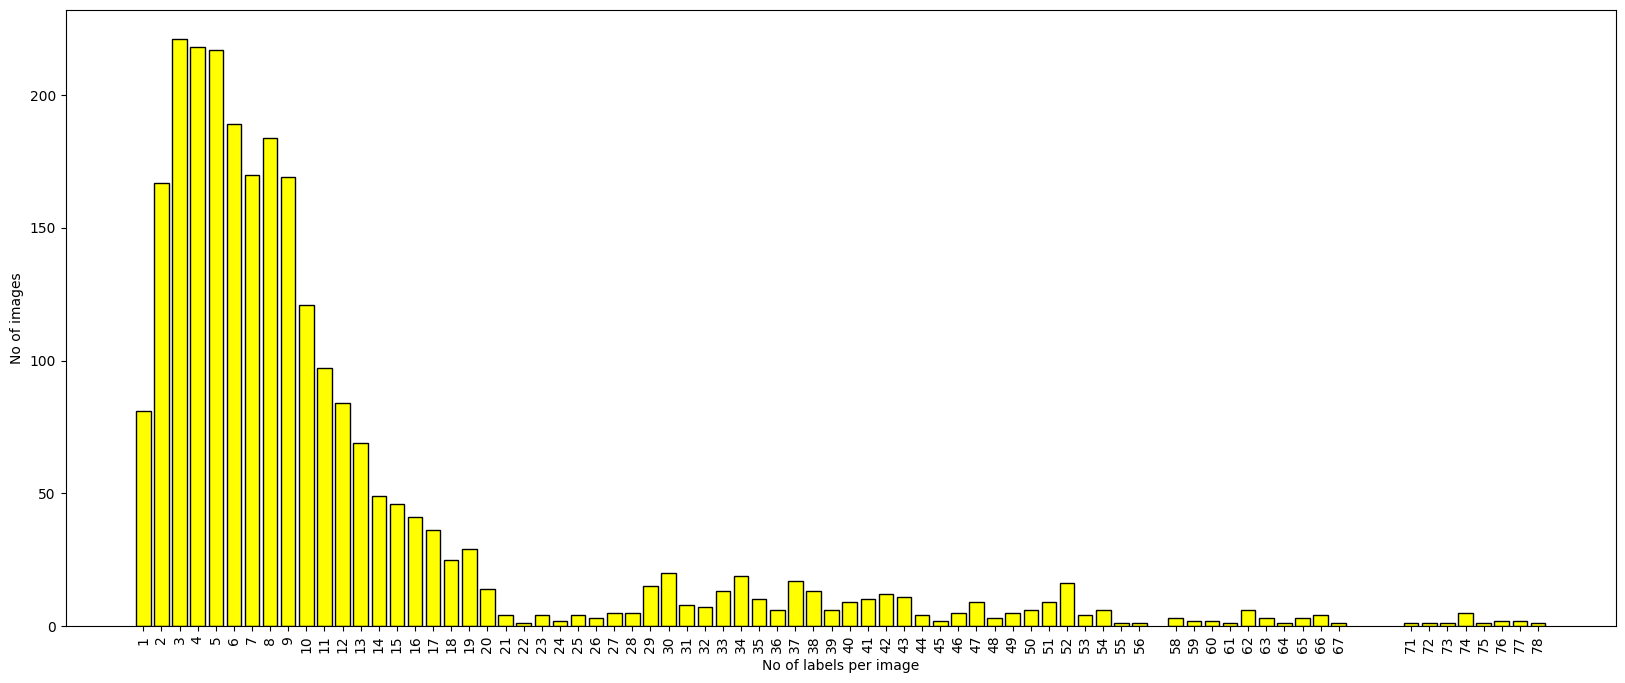

In [4]:
import matplotlib.pyplot as plt

from collections import Counter
count_distribution = Counter(label_count)

labels = list(count_distribution.keys())
images = list(count_distribution.values())

plt.figure(figsize = (20,8))
plt.bar(labels, images, color = "yellow", edgecolor = "black")
plt.xlabel("No of labels per image")
plt.ylabel("No of images")
plt.xticks(labels, rotation = 90)
plt.show()

### **What method was used to compute the area (in meters) for a single instance?**

In [5]:
areas = []

for filename in os.listdir("/content/labels/labels_native"):
  file_path = os.path.join("/content/labels/labels_native", filename)

  with open(file_path, "r") as f:
    lines = [line for line in f.read().splitlines() if line.strip()]

    for line in lines:
      values = line.split()

      width = float(values[3])
      height = float(values[4])

      area = width * height * 0.31 * 0.31 * 416 * 416
      areas.append(area)

### **What is the mean area and standard deviation?**

In [6]:
import numpy as np

mean = np.mean(np.array(areas))
std = np.std(np.array(areas))

max = np.max(np.array(areas))
min = np.min(np.array(areas))

print(f"Mean of areas is : {mean} m^2")
print(f"Standard Deviation of areas is : {std} m^2")
print(f"Max of areas is : {max} m^2")
print(f"Min of areas is : {min} m^2")

Mean of areas is : 191.51782786497895 m^2
Standard Deviation of areas is : 630.7003355500087 m^2
Max of areas is : 12177.407600000002 m^2
Min of areas is : 1.0571000000000004 m^2


### **Plot the histogram of areas. What do you observe?**

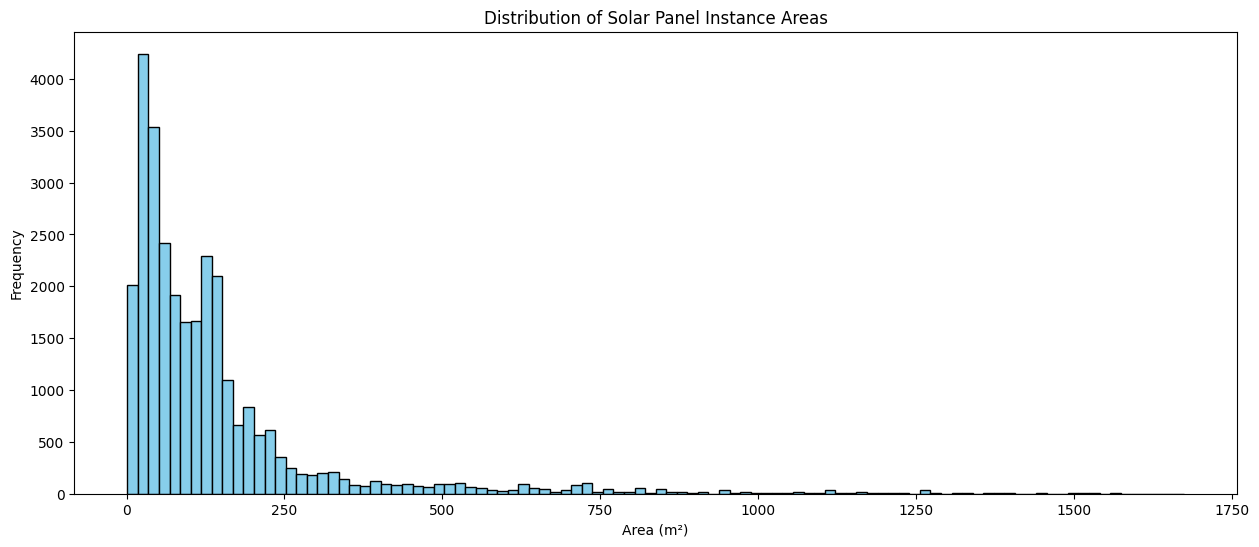

In [7]:
cutoff = np.percentile(areas, 99)
clipped_areas = [a for a in areas if a <= cutoff]

plt.figure(figsize=(15, 6))
plt.hist(clipped_areas, bins=100, color='skyblue', edgecolor='black')
plt.xlabel("Area (m²)")
plt.ylabel("Frequency")
plt.title("Distribution of Solar Panel Instance Areas")
plt.show()

### **Write a function to compute IoU (Intersection over Union) between two axis-aligned bounding boxes specified in the Ultralytics YOLO format. You MUST use the shapely library and its functionalities to write your function. Show that your function provides the same or similar answer as IoU computed using `supervision` library**

In [8]:
!pip install shapely

In [9]:
import shapely
from shapely.geometry import Polygon

def box_to_polygon(box):

  # here box is an arary wich has [category, x center, y center, x width, y width]

  xmin = box[1] - box[3] / 2
  xmax = box[1] + box[3] / 2
  ymin = box[2] - box[4] / 2
  ymax = box[2] + box[4] / 2

  return Polygon([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin)])

def IOU_using_shapely(box1, box2):

  polygon1 = box_to_polygon(box1)
  polygon2 = box_to_polygon(box2)

  intersection = polygon1.intersection(polygon2)
  union = polygon1.union(polygon2)

  IOU =  intersection.area / union.area

  return IOU

In [10]:
!pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 16.5 MB/s eta 0:00:00


In [11]:
import supervision as sv

def sv_format(box):

  xmin = box[1] - box[3] / 2
  xmax = box[1] + box[3] / 2
  ymin = box[2] - box[4] / 2
  ymax = box[2] + box[4] / 2

  return [xmin, ymin, xmax, ymax]


def IOU_using_sv(box1, box2):

  box1 = np.array(sv_format(box1))
  box2 = np.array(sv_format(box2))

  iou = sv.detection.utils.box_iou_batch(box1[None, :], box2[None, :])
  return iou

In [12]:
box1 = np.array([0.0, 0.87259615, 0.70072115, 0.05769231, 0.05528846])
box2 = np.array([0.0, 0.880, 0.710, 0.050, 0.050])

In [13]:
IOU_using_shapely(box1, box2)

0.5479150489472867

In [14]:
IOU_using_sv(box1, box2)

array([[0.54791505]])

### **Use Pascal VOC 11 point interpolation method to implement the Average Precision (AP)**

In [15]:
def VOC_11_AP(recalls, precisions):

  recalls = np.array(recalls)
  precisions = np.array(precisions)

  recall_thresholds = np.linspace(0,1,11)

  ap = 0.0

  for t in recall_thresholds:
    if np.any(recalls >= t) :
      p = np.max(precisions[recalls >= t])
    else :
      p = 0.0
    ap += p

  ap /= 11
  return ap

### **Use COCO 101-point interpolation method to implement the Average Precision (AP)**

In [16]:
def COCO_11_AP(recalls, precisions):

  recalls = np.array(recalls)
  precisions = np.array(precisions)

  recall_thresholds = np.linspace(0, 1, 101)

  ap = 0.0

  for t in recall_thresholds:
    if np.any(recalls >= t):
      p = np.max(precisions[recalls >= t])
    else :
      p = 0.0
    ap += p

  ap /= 101
  return ap

### **Use Area under Precision-Recall Curve (AP) method to implement the Average Precision (AP)**

In [17]:
def PR_curve_AP(recalls, precisions):

  recalls = np.array(recalls)
  precisions = np.array(precisions)

  ap = np.trapz(precisions, recalls)
  return ap

### **Randomly generate 10 images of size 100x100. Randomly generate 10 ground truth boxes of size 20x20 and 10 predicted boxes of size 20x20 in each image. Assume there is only one class of objects. Compare the AP50 (Average Precision at IoU 0.5) computed by 3 of your methods**

In [18]:
def generate_random_images(num_images, image_size):

  images = []

  for _ in range(num_images):

    image = np.random.randint(0, 256, (image_size[1], image_size[0], 3))
    images.append(image)

  return images



def generate_random_boxes(num_boxes, image_size, box_size):

  boxes = []

  x_ = image_size[0] - box_size[0]
  y_ = image_size[1] - box_size[1]

  for _ in range(num_boxes):

    x_center = np.random.randint(0, x_ + 1) + box_size[0] / 2

    y_center = np.random.randint(0, y_ + 1) + box_size[1] / 2

    boxes.append([0, x_center, y_center, box_size[0], box_size[1]])

  return np.array(boxes)



def slightly_overlapping_predicted_boxes(gt_boxes, offset_range):

  pred_boxes = []

  for box in gt_boxes:

    offset_x = np.random.randint(offset_range[0], offset_range[1] + 1)
    offset_y = np.random.randint(offset_range[0], offset_range[1] + 1)

    x_center = box[1] + offset_x
    y_center = box[2] + offset_y

    pred_boxes.append([0, x_center, y_center, box[3], box[4]])

  return np.array(pred_boxes)

In [19]:
images = generate_random_images(10, (100, 100))

pred = np.zeros((10,10))

for i in range(10):

  ground_truth_boxes = generate_random_boxes(10, (100, 100), (20, 20))
  predicted_boxes = slightly_overlapping_predicted_boxes(ground_truth_boxes, (-5,5))

  for j in range(10):

    iou = IOU_using_shapely(ground_truth_boxes[j], predicted_boxes[j])
    if iou >= 0.5:

      pred[i][j] = 1

In [20]:
pred

array([[1., 0., 1., 1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 0., 0., 0., 1., 1., 1., 0., 0.],
       [1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 0., 1., 1.],
       [0., 1., 1., 1., 1., 1., 0., 0., 1., 0.],
       [1., 0., 1., 1., 1., 0., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 0., 0., 1., 0.],
       [1., 1., 0., 1., 1., 1., 1., 0., 1., 1.]])

In [21]:
Recalls = []
Precisions = []

for i in range(10):
  for j in range(10):
    value = pred[i][j]

    Recalls.append(value)
    Precisions.append(value)

In [22]:
VOC_11_AP(Recalls, Precisions)

1.0

In [23]:
COCO_11_AP(Recalls, Precisions)

1.0

In [24]:
PR_curve_AP(Recalls, Precisions)

0.0

### **Split the data into 80-20 train-test split. Use 10% of training data as validation.**

In [25]:
with zipfile.ZipFile("/content/image_chips_native-20250212T103727Z-001.zip", "r") as zip_ref:
  zip_ref.extractall("/content/")

In [26]:
image_dir = "/content/image_chips_native"
label_dir = "/content/labels/labels_native"

image_files = [f for f in os.listdir(image_dir) if f.endswith(".tif") or f.endswith(".tiff")]
label_files = [f.replace(".txt", ".tif") for f in os.listdir(label_dir) if f.endswith(".txt")]


images_without_labels=[]
for img in image_files:
    if img not in label_files:
        images_without_labels.append(img)

for img in images_without_labels:
    img_path = os.path.join(image_dir, img)
    os.remove(img_path)

In [27]:
import random
import shutil

base_dir = "/content/dataset"
image_dir = os.path.join(base_dir, "/content/image_chips_native")
label_dir = os.path.join(base_dir, "/content/labels/labels_native")

train_image_dir = os.path.join(base_dir, "train/images")
train_label_dir = os.path.join(base_dir, "train/labels")
val_image_dir = os.path.join(base_dir, "val/images")
val_label_dir = os.path.join(base_dir, "val/labels")

for d in [train_image_dir, train_label_dir, val_image_dir, val_label_dir]:
    os.makedirs(d, exist_ok=True)

image_files=[]
for f in os.listdir(image_dir):
    if f.endswith(".tif"):
        image_files.append(f)
random.shuffle(image_files)

train_ratio = 0.8
train_size = int(len(image_files) * train_ratio)

train_files = image_files[:train_size]
val_files = image_files[train_size:]

for file in train_files:
    shutil.move(os.path.join(image_dir, file), os.path.join(train_image_dir, file))
    shutil.move(os.path.join(label_dir, file.replace(".tif", ".txt")), os.path.join(train_label_dir, file.replace(".tif", ".txt")))

for file in val_files:
    shutil.move(os.path.join(image_dir, file), os.path.join(val_image_dir, file))
    shutil.move(os.path.join(label_dir, file.replace(".tif", ".txt")), os.path.join(val_label_dir, file.replace(".tif", ".txt")))

print(f"Dataset split complete: {len(train_files)} train images, {len(val_files)} validation images.")

Dataset split complete: 2033 train images, 509 validation images.


In [28]:
dataset_path = "/content/dataset"
train_images_path = os.path.join(dataset_path, "train", "images")
train_labels_path = os.path.join(dataset_path, "train", "labels")

val_images_path = os.path.join(dataset_path, "test", "images")
val_labels_path = os.path.join(dataset_path, "test", "labels")

os.makedirs(val_images_path, exist_ok=True)
os.makedirs(val_labels_path, exist_ok=True)

image_files_1=[]
for f in os.listdir(train_images_path):
    if f.endswith(".tif"):
        image_files_1.append(f)
random.shuffle(image_files_1)

num_val = int(0.1 * len(image_files))

moved_count = 0
for img_file in image_files[:num_val]:
    img_path = os.path.join(train_images_path, img_file)
    label_file = img_file.rsplit(".", 1)[0] + ".txt"
    label_path = os.path.join(train_labels_path, label_file)

    if os.path.exists(img_path):
        shutil.move(img_path, os.path.join(val_images_path, img_file))
    if os.path.exists(label_path):
        shutil.move(label_path, os.path.join(val_labels_path, label_file))

    moved_count += 1

### **Use any model from Ultralytics like YOLO to train the object detection model. Show that validation loss is converged.**

In [29]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.1/922.1 kB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [30]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 329MB/s]


In [31]:
data_yaml = f"""path: {base_dir}
train: /content/dataset/train/images
val: /content/dataset/val/images
test: /content/dataset/test/images

nc: 1  # Number of classes (change this if you have more than 1 class)
names: ['solar panel']  # Replace 'object' with the actual class name
augment: True  # Enable default augmentations
dropout: 0.2
"""

with open(os.path.join(base_dir, "data.yaml"), "w") as f:
    f.write(data_yaml)

In [32]:
results = model.train(
    data="/content/dataset/data.yaml",
    epochs=10,
    batch=16,
    imgsz=416,
    val=True,
    save=True,
    name="solar_panels_model",
    conf=0.15,
    iou=0.5,
    lr0=1e-3,
)

Ultralytics 8.3.81 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/dataset/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=solar_panels_model, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=0.15, iou=0.5, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tru

100%|██████████| 755k/755k [00:00<00:00, 116MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 484MB/s]


AMP: checks passed ✅


train: Scanning /content/dataset/train/labels... 1779 images, 0 backgrounds, 171 corrupt: 100%|██████████| 1779/1779 [00:01<00:00, 985.19it/s] 

train: WARNING ⚠️ /content/dataset/train/images/solarpanels_native_1__x0_0_y0_7119_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /content/dataset/train/images/solarpanels_native_1__x0_0_y0_7229_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /content/dataset/train/images/solarpanels_native_1__x0_0_y0_7230_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /content/dataset/train/images/solarpanels_native_1__x0_0_y0_7249_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /content/dataset/train/images/solarpanels_native_1__x0_128_y0_7056_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class lab

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/dataset/val/labels... 509 images, 0 backgrounds, 35 corrupt: 100%|██████████| 509/509 [00:00<00:00, 802.78it/s]

val: WARNING ⚠️ /content/dataset/val/images/solarpanels_native_1__x0_0_y0_6963_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /content/dataset/val/images/solarpanels_native_1__x0_139_y0_6989_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /content/dataset/val/images/solarpanels_native_1__x0_2068_y0_7597_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /content/dataset/val/images/solarpanels_native_1__x0_318_y0_7394_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /content/dataset/val/images/solarpanels_native_1__x0_7374_y0_9622_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0


Plotting labels to runs/detect/solar_panels_model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to runs/detect/solar_panels_model
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.08G      1.841      2.076      1.366        109        416: 100%|██████████| 101/101 [00:10<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  5.99it/s]

                   all        474       5618      0.967       0.18      0.574      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10       1.2G      1.581      1.287      1.196        124        416: 100%|██████████| 101/101 [00:08<00:00, 11.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  7.45it/s]

                   all        474       5618      0.719      0.681       0.72      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.18G      1.513      1.186      1.149         83        416: 100%|██████████| 101/101 [00:08<00:00, 11.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  7.43it/s]

                   all        474       5618      0.801      0.723      0.805      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.13G      1.444      1.061      1.125         46        416: 100%|██████████| 101/101 [00:08<00:00, 11.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  7.38it/s]

                   all        474       5618      0.839      0.733       0.83      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.26G      1.362     0.9786      1.094         40        416: 100%|██████████| 101/101 [00:08<00:00, 11.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  7.25it/s]

                   all        474       5618       0.86      0.761      0.849      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.18G      1.319     0.9207      1.077         80        416: 100%|██████████| 101/101 [00:08<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  7.34it/s]

                   all        474       5618      0.855      0.789      0.864      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.18G      1.245     0.8512      1.046         56        416: 100%|██████████| 101/101 [00:08<00:00, 11.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  7.40it/s]

                   all        474       5618       0.88      0.813      0.888      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.22G      1.213     0.8147      1.025         57        416: 100%|██████████| 101/101 [00:08<00:00, 11.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  7.41it/s]

                   all        474       5618      0.889      0.826      0.902      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.18G       1.16      0.763      1.006         92        416: 100%|██████████| 101/101 [00:08<00:00, 11.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00,  7.50it/s]

                   all        474       5618      0.882      0.833      0.899      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.11G      1.142     0.7454          1         60        416: 100%|██████████| 101/101 [00:08<00:00, 11.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:02<00:00,  6.77it/s]

                   all        474       5618      0.892      0.857      0.919      0.689



10 epochs completed in 0.033 hours.
Optimizer stripped from runs/detect/solar_panels_model/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/solar_panels_model/weights/best.pt, 6.2MB

Validating runs/detect/solar_panels_model/weights/best.pt...
Ultralytics 8.3.81 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.63it/s]


                   all        474       5618      0.893      0.857      0.919      0.689
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/solar_panels_model


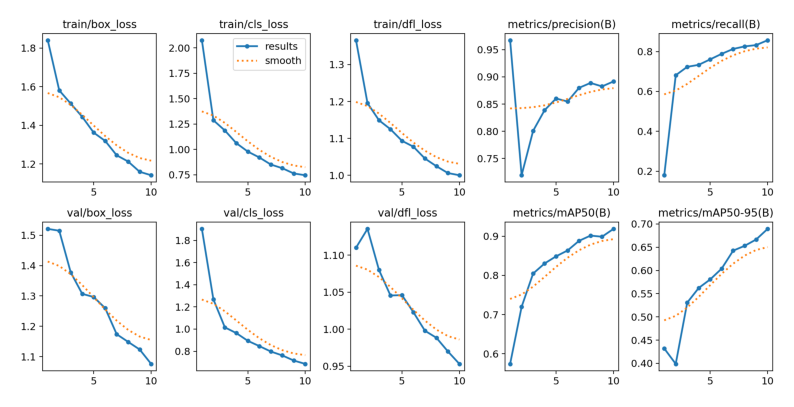

In [33]:
image_path = "/content/runs/detect/solar_panels_model/results.png"

img = plt.imread(image_path)
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis("off")
plt.show()

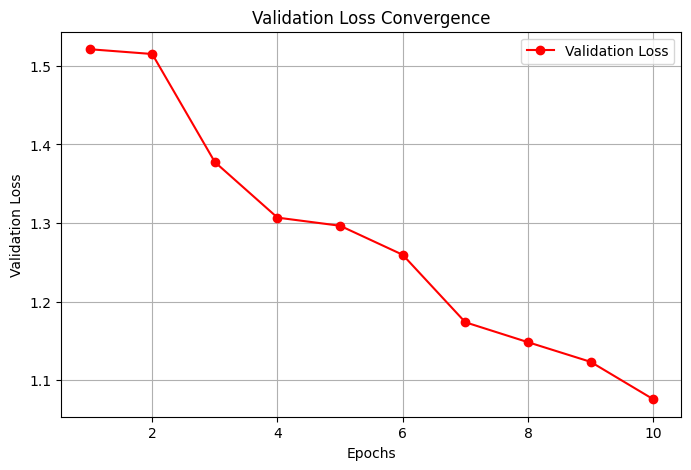

In [34]:
import pandas as pd

results_csv = "/content/runs/detect/solar_panels_model/results.csv"

df = pd.read_csv(results_csv)

plt.figure(figsize=(8, 5))
plt.plot(df["epoch"], df["val/box_loss"], marker="o", label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Convergence")
plt.legend()
plt.grid()
plt.show()

### **Predict solar panels using the trained model. Visualize the ground truth and predicted bounding boxes on 3-4 random samples from the test dataset. Use appropriate color schemes to differentiate between ground truth and predicted labels.**

In [36]:
model = YOLO("/content/runs/detect/solar_panels_model/weights/best.pt")

In [38]:
import cv2
import torch

test_images_path = "//content/dataset/test/images"
test_labels_path = "/content/dataset/test/labels"

image_files = []
for f in os.listdir(test_images_path):
    if f.endswith(".tif"):
        image_files.append(f)

random_images = random.sample(image_files, 3)


image 1/1 //content/dataset/test/images/solarpanels_native_2__x0_0_y0_894_dxdy_416.tif: 416x416 7 solar panels, 6.9ms
Speed: 1.0ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)


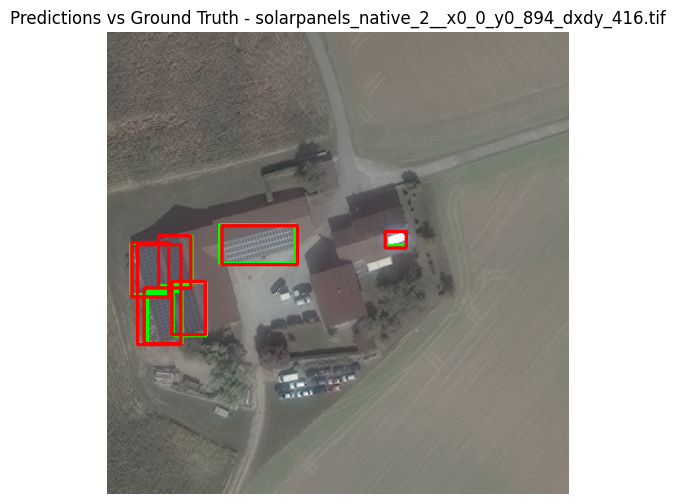


image 1/1 //content/dataset/test/images/solarpanels_native_3__x0_8741_y0_13767_dxdy_416.tif: 416x416 4 solar panels, 8.8ms
Speed: 1.0ms preprocess, 8.8ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)


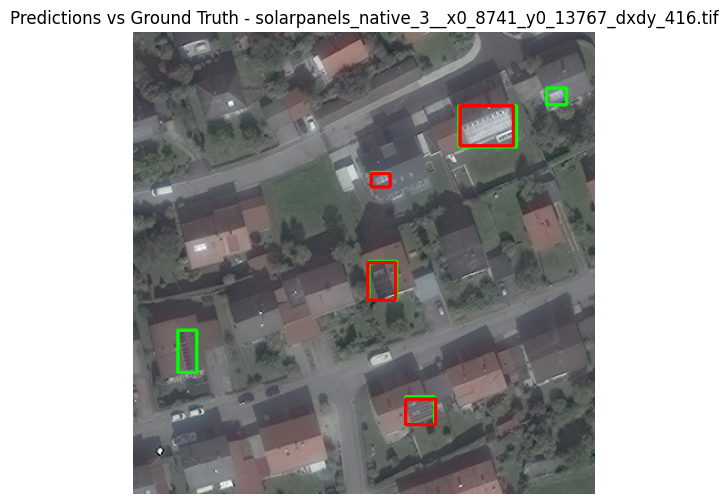


image 1/1 //content/dataset/test/images/solarpanels_native_2__x0_494_y0_10999_dxdy_416.tif: 416x416 43 solar panels, 9.4ms
Speed: 1.1ms preprocess, 9.4ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)


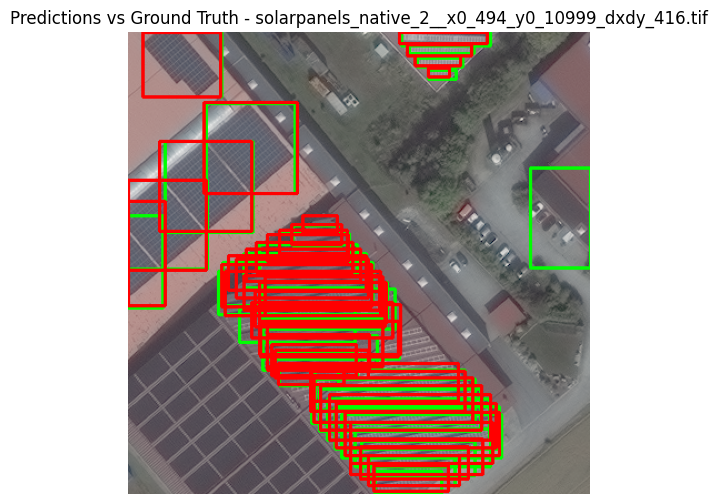

In [40]:
gt_clr = (0, 255, 0)
pred_clr = (0, 0, 255)


def read_yolo_labels(label_path):
    boxes = []
    with open(label_path, "r") as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            x_center, y_center, w, h = map(float, parts[1:])
            boxes.append((x_center, y_center, w, h))
    return boxes

def yolo_to_pixel(boxes, img_w, img_h):
    pixel_boxes = []
    for box in boxes:
        x_c, y_c, w, h = box
        x1 = int((x_c - w / 2) * img_w)
        y1 = int((y_c - h / 2) * img_h)
        x2 = int((x_c + w / 2) * img_w)
        y2 = int((y_c + h / 2) * img_h)
        pixel_boxes.append((x1, y1, x2, y2))
    return pixel_boxes

for image_name in random_images:
    image_path = os.path.join(test_images_path, image_name)
    label_path = os.path.join(test_labels_path, image_name.replace(".tif", ".txt"))

    image = cv2.imread(image_path)
    h, w, _ = image.shape

    if os.path.exists(label_path):
        gt_boxes = read_yolo_labels(label_path)
        gt_boxes = yolo_to_pixel(gt_boxes, w, h)
        for (x1, y1, x2, y2) in gt_boxes:
            cv2.rectangle(image, (x1, y1), (x2, y2), gt_clr, 2)

    results = model(image_path)
    for result in results:
        for box in result.boxes.xyxy:
            x1, y1, x2, y2 = map(int, box[:4])
            cv2.rectangle(image, (x1, y1), (x2, y2), pred_clr, 2)

    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Predictions vs Ground Truth - {image_name}")
    plt.axis("off")
    plt.show()

### **Compute mAP50 with supervision**

In [41]:
def read_yolo_labels_1(label_path, img_w, img_h):
    boxes = []
    with open(label_path, 'r') as file:
        for line in file.readlines():
            values = line.strip().split()
            if len(values) == 5:
                category, x_c, y_c, w, h = map(float, values)
                x1 = int((x_c - w / 2) * img_w)
                y1 = int((y_c - h / 2) * img_h)
                x2 = int((x_c + w / 2) * img_w)
                y2 = int((y_c + h / 2) * img_h)
                boxes.append([x1, y1, x2, y2, int(category)])
    return np.array(boxes) if boxes else np.empty((0, 5))


test_images_path = "/content/dataset/test/images"
gt_labels_path = "/content/dataset/test/labels"

from tqdm import tqdm
all_predictions = []
all_ground_truths = []

image_files_3 = []
for f in os.listdir(test_images_path):
    if f.endswith('.tif'):
        image_files_3.append(f)

for img_file in tqdm(image_files, desc="Evaluating"):
    img_path = os.path.join(test_images_path, img_file)
    label_path = os.path.join(gt_labels_path, img_file.replace(".tif", ".txt"))

    image = cv2.imread(img_path)
    if image is None:
        continue
    original_h, original_w, _ = image.shape

    if os.path.exists(label_path):
        gt_boxes = read_yolo_labels_1(label_path, original_w, original_h)
        all_ground_truths.append(sv.Detections(xyxy=gt_boxes[:, :4], class_id=gt_boxes[:, 4]))

    results = model(img_path, imgsz=416, conf=0.25)
    for result in results:
        if result.boxes is not None:
            pred_boxes = result.boxes.xyxy.cpu().numpy()
            pred_scores = result.boxes.conf.cpu().numpy()
            pred_classes = result.boxes.cls.cpu().numpy()
            detections = sv.Detections(xyxy=pred_boxes, confidence=pred_scores, class_id=pred_classes)
            all_predictions.append(detections)

Evaluating:   0%|          | 0/254 [00:00<?, ?it/s]


image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_8888_y0_13557_dxdy_416.tif: 416x416 5 solar panels, 7.6ms
Speed: 1.0ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_7403_y0_13361_dxdy_416.tif: 416x416 1 solar panel, 6.6ms
Speed: 0.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_9490_y0_10558_dxdy_416.tif: 416x416 10 solar panels, 7.3ms
Speed: 0.8ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_3472_y0_13154_dxdy_416.tif: 416x416 9 solar panels, 6.6ms
Speed: 0.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_1389_y0_9180_dxdy_416.tif: 416x416 8 solar panels, 6.7ms
Sp

Evaluating:   3%|▎         | 8/254 [00:00<00:03, 74.80it/s]


image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_10290_y0_9776_dxdy_416.tif: 416x416 40 solar panels, 6.4ms
Speed: 0.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_2646_y0_9553_dxdy_416.tif: 416x416 5 solar panels, 6.5ms
Speed: 0.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_6870_y0_12292_dxdy_416.tif: 416x416 34 solar panels, 6.2ms
Speed: 0.8ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_1623_y0_6705_dxdy_416.tif: 416x416 11 solar panels, 6.3ms
Speed: 0.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_9715_y0_9476_dxdy_416.tif: 416x416 4 solar panels, 6.5ms
S

Evaluating:   6%|▋         | 16/254 [00:00<00:03, 76.83it/s]


image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_3674_y0_12943_dxdy_416.tif: 416x416 13 solar panels, 6.4ms
Speed: 0.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_6221_y0_12249_dxdy_416.tif: 416x416 15 solar panels, 6.7ms
Speed: 0.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_6033_y0_12692_dxdy_416.tif: 416x416 6 solar panels, 6.3ms
Speed: 0.8ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_8166_y0_8730_dxdy_416.tif: 416x416 10 solar panels, 6.5ms
Speed: 0.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_3530_y0_10812_dxdy_416.tif: 416x416 2 solar panels, 6.3ms

Evaluating:   9%|▉         | 24/254 [00:00<00:02, 78.13it/s]


image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_5909_y0_8922_dxdy_416.tif: 416x416 3 solar panels, 6.3ms
Speed: 1.1ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_11868_y0_9081_dxdy_416.tif: 416x416 47 solar panels, 7.7ms
Speed: 0.8ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_3760_y0_11575_dxdy_416.tif: 416x416 23 solar panels, 6.3ms
Speed: 0.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_2628_y0_12917_dxdy_416.tif: 416x416 3 solar panels, 6.9ms
Speed: 0.9ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_5588_y0_6163_dxdy_416.tif: 416x416 7 solar panels, 6.4ms
S

Evaluating:  13%|█▎        | 32/254 [00:00<00:02, 77.67it/s]


image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_3416_y0_1960_dxdy_416.tif: 416x416 1 solar panel, 6.8ms
Speed: 0.9ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_3990_y0_13252_dxdy_416.tif: 416x416 11 solar panels, 6.4ms
Speed: 0.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_9358_y0_3629_dxdy_416.tif: 416x416 6 solar panels, 6.3ms
Speed: 0.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_3744_y0_12441_dxdy_416.tif: 416x416 1 solar panel, 12.4ms
Speed: 1.2ms preprocess, 12.4ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_6294_y0_11972_dxdy_416.tif: 416x416 8 solar panels, 9.2ms
Sp

Evaluating:  16%|█▌        | 40/254 [00:00<00:02, 72.84it/s]


image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_830_y0_10619_dxdy_416.tif: 416x416 61 solar panels, 7.2ms
Speed: 0.9ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_11652_y0_9091_dxdy_416.tif: 416x416 54 solar panels, 7.9ms
Speed: 0.9ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_8199_y0_0_dxdy_416.tif: 416x416 3 solar panels, 6.6ms
Speed: 0.8ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_2539_y0_4835_dxdy_416.tif: 416x416 14 solar panels, 6.6ms
Speed: 0.9ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_940_y0_7670_dxdy_416.tif: 416x416 13 solar panels, 6.4ms
Speed

Evaluating:  19%|█▉        | 48/254 [00:00<00:02, 73.00it/s]


image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_1047_y0_8876_dxdy_416.tif: 416x416 13 solar panels, 6.0ms
Speed: 0.8ms preprocess, 6.0ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_8833_y0_12288_dxdy_416.tif: 416x416 13 solar panels, 6.2ms
Speed: 0.8ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_9879_y0_14596_dxdy_416.tif: 416x416 6 solar panels, 6.3ms
Speed: 0.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_0_y0_13730_dxdy_416.tif: 416x416 6 solar panels, 6.3ms
Speed: 0.7ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_5414_y0_14240_dxdy_416.tif: 416x416 3 solar panels, 6.5ms
Spe

Evaluating:  22%|██▏       | 57/254 [00:00<00:02, 75.73it/s]


image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_9486_y0_13744_dxdy_416.tif: 416x416 9 solar panels, 6.1ms
Speed: 0.8ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_1143_y0_40_dxdy_416.tif: 416x416 2 solar panels, 6.0ms
Speed: 0.8ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_5265_y0_13256_dxdy_416.tif: 416x416 6 solar panels, 6.3ms
Speed: 0.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_6932_y0_11784_dxdy_416.tif: 416x416 3 solar panels, 6.2ms
Speed: 0.9ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_2499_y0_10481_dxdy_416.tif: 416x416 5 solar panels, 5.8ms
Spee

Evaluating:  26%|██▌       | 66/254 [00:00<00:02, 77.76it/s]


image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_1300_y0_10050_dxdy_416.tif: 416x416 4 solar panels, 5.9ms
Speed: 0.8ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_11625_y0_9272_dxdy_416.tif: 416x416 42 solar panels, 6.1ms
Speed: 0.8ms preprocess, 6.1ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_6975_y0_10016_dxdy_416.tif: 416x416 4 solar panels, 6.1ms
Speed: 0.8ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_9373_y0_10823_dxdy_416.tif: 416x416 13 solar panels, 6.1ms
Speed: 0.8ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_366_y0_7369_dxdy_416.tif: 416x416 5 solar panels, 6.2ms
S

Evaluating:  30%|██▉       | 75/254 [00:00<00:02, 78.90it/s]


image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_668_y0_10429_dxdy_416.tif: 416x416 55 solar panels, 6.6ms
Speed: 0.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_6914_y0_12303_dxdy_416.tif: 416x416 28 solar panels, 6.4ms
Speed: 0.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_11058_y0_12848_dxdy_416.tif: 416x416 4 solar panels, 6.2ms
Speed: 0.9ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_7632_y0_9852_dxdy_416.tif: 416x416 10 solar panels, 6.3ms
Speed: 0.8ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_4363_y0_15474_dxdy_416.tif: 416x416 10 solar panels, 6.2m

Evaluating:  33%|███▎      | 83/254 [00:01<00:02, 79.03it/s]


image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_792_y0_10381_dxdy_416.tif: 416x416 48 solar panels, 6.9ms
Speed: 0.9ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_3122_y0_12828_dxdy_416.tif: 416x416 5 solar panels, 6.1ms
Speed: 0.8ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_11100_y0_12917_dxdy_416.tif: 416x416 7 solar panels, 6.0ms
Speed: 0.8ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_1602_y0_8090_dxdy_416.tif: 416x416 4 solar panels, 6.0ms
Speed: 0.8ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_8974_y0_12738_dxdy_416.tif: 416x416 4 solar panels, 6.0ms
S

Evaluating:  36%|███▌      | 92/254 [00:01<00:02, 79.42it/s]


image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_7615_y0_12134_dxdy_416.tif: 416x416 3 solar panels, 6.1ms
Speed: 0.8ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_2270_y0_6830_dxdy_416.tif: 416x416 6 solar panels, 6.4ms
Speed: 0.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_8747_y0_10580_dxdy_416.tif: 416x416 2 solar panels, 6.0ms
Speed: 0.9ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_8462_y0_4064_dxdy_416.tif: 416x416 19 solar panels, 6.1ms
Speed: 0.8ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_8043_y0_12190_dxdy_416.tif: 416x416 25 solar panels, 6.2ms
S

Evaluating:  40%|███▉      | 101/254 [00:01<00:01, 79.80it/s]


image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_6272_y0_11293_dxdy_416.tif: 416x416 4 solar panels, 7.0ms
Speed: 0.9ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_9436_y0_2624_dxdy_416.tif: 416x416 5 solar panels, 6.0ms
Speed: 0.8ms preprocess, 6.0ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_11051_y0_2289_dxdy_416.tif: 416x416 5 solar panels, 6.9ms
Speed: 0.8ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_11313_y0_12214_dxdy_416.tif: 416x416 4 solar panels, 7.2ms
Speed: 0.9ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_4360_y0_11976_dxdy_416.tif: 416x416 1 solar panel, 9.1ms
Sp

Evaluating:  43%|████▎     | 109/254 [00:01<00:01, 78.19it/s]


image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_7957_y0_8387_dxdy_416.tif: 416x416 29 solar panels, 7.2ms
Speed: 0.8ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_8446_y0_2935_dxdy_416.tif: 416x416 7 solar panels, 6.2ms
Speed: 0.8ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_0_y0_7840_dxdy_416.tif: 416x416 8 solar panels, 6.2ms
Speed: 0.8ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_7549_y0_12271_dxdy_416.tif: 416x416 3 solar panels, 6.3ms
Speed: 0.8ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_3641_y0_10347_dxdy_416.tif: 416x416 3 solar panels, 6.1ms
Speed:

Evaluating:  46%|████▌     | 117/254 [00:01<00:01, 78.48it/s]


image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_269_y0_14719_dxdy_416.tif: 416x416 2 solar panels, 6.2ms
Speed: 0.8ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_10164_y0_9908_dxdy_416.tif: 416x416 46 solar panels, 9.9ms
Speed: 0.9ms preprocess, 9.9ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_9331_y0_11009_dxdy_416.tif: 416x416 10 solar panels, 6.3ms
Speed: 0.9ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_4883_y0_13756_dxdy_416.tif: 416x416 6 solar panels, 5.9ms
Speed: 0.8ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_8029_y0_11763_dxdy_416.tif: 416x416 2 solar panels, 6.6ms


Evaluating:  49%|████▉     | 125/254 [00:01<00:01, 77.59it/s]


image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_5816_y0_5494_dxdy_416.tif: 416x416 12 solar panels, 6.1ms
Speed: 0.8ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_7852_y0_10603_dxdy_416.tif: 416x416 11 solar panels, 6.5ms
Speed: 0.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_7438_y0_9843_dxdy_416.tif: 416x416 3 solar panels, 6.6ms
Speed: 0.8ms preprocess, 6.6ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_12687_y0_10823_dxdy_416.tif: 416x416 8 solar panels, 7.3ms
Speed: 1.0ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_3069_y0_3749_dxdy_416.tif: 416x416 3 solar panels, 6.4ms
S

Evaluating:  52%|█████▏    | 133/254 [00:01<00:01, 76.04it/s]


image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_1763_y0_6695_dxdy_416.tif: 416x416 17 solar panels, 6.3ms
Speed: 0.9ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_9471_y0_3791_dxdy_416.tif: 416x416 8 solar panels, 6.2ms
Speed: 0.8ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_1841_y0_7154_dxdy_416.tif: 416x416 7 solar panels, 7.7ms
Speed: 0.8ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_404_y0_14230_dxdy_416.tif: 416x416 3 solar panels, 7.0ms
Speed: 0.9ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_4161_y0_15343_dxdy_416.tif: 416x416 8 solar panels, 7.0ms
Spee

Evaluating:  56%|█████▌    | 141/254 [00:01<00:01, 76.24it/s]


image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_2684_y0_4828_dxdy_416.tif: 416x416 14 solar panels, 6.1ms
Speed: 0.8ms preprocess, 6.1ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_1774_y0_9961_dxdy_416.tif: 416x416 4 solar panels, 5.9ms
Speed: 0.8ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_11643_y0_9250_dxdy_416.tif: 416x416 45 solar panels, 5.9ms
Speed: 0.8ms preprocess, 5.9ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_12217_y0_11484_dxdy_416.tif: 416x416 13 solar panels, 7.2ms
Speed: 0.8ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_9322_y0_9896_dxdy_416.tif: 416x416 2 solar panels, 6.1ms


Evaluating:  59%|█████▊    | 149/254 [00:01<00:01, 77.20it/s]


image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_10090_y0_3312_dxdy_416.tif: 416x416 9 solar panels, 6.3ms
Speed: 0.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_8092_y0_10423_dxdy_416.tif: 416x416 5 solar panels, 6.3ms
Speed: 0.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_13908_y0_15968_dxdy_416.tif: 416x416 (no detections), 6.4ms
Speed: 0.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_1683_y0_9664_dxdy_416.tif: 416x416 5 solar panels, 6.1ms
Speed: 0.8ms preprocess, 6.1ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_5382_y0_11947_dxdy_416.tif: 416x416 1 solar panel, 6.1ms
S

Evaluating:  62%|██████▏   | 158/254 [00:02<00:01, 78.07it/s]


image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_12410_y0_10958_dxdy_416.tif: 416x416 9 solar panels, 6.4ms
Speed: 0.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_8119_y0_12186_dxdy_416.tif: 416x416 28 solar panels, 6.4ms
Speed: 0.8ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_5847_y0_13234_dxdy_416.tif: 416x416 5 solar panels, 6.6ms
Speed: 0.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_5532_y0_5173_dxdy_416.tif: 416x416 8 solar panels, 6.3ms
Speed: 1.1ms preprocess, 6.3ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_8189_y0_12171_dxdy_416.tif: 416x416 9 solar panels, 6.3ms


Evaluating:  65%|██████▌   | 166/254 [00:02<00:01, 77.70it/s]


image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_5005_y0_12514_dxdy_416.tif: 416x416 9 solar panels, 6.1ms
Speed: 0.8ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_8248_y0_7817_dxdy_416.tif: 416x416 13 solar panels, 6.3ms
Speed: 0.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_6503_y0_12150_dxdy_416.tif: 416x416 22 solar panels, 6.3ms
Speed: 1.1ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_4643_y0_11705_dxdy_416.tif: 416x416 13 solar panels, 6.0ms
Speed: 0.8ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_691_y0_10938_dxdy_416.tif: 416x416 30 solar panels, 6.4ms

Evaluating:  69%|██████▊   | 174/254 [00:02<00:01, 78.26it/s]


image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_2447_y0_4599_dxdy_416.tif: 416x416 13 solar panels, 6.0ms
Speed: 0.8ms preprocess, 6.0ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_2282_y0_7116_dxdy_416.tif: 416x416 7 solar panels, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_1146_y0_0_dxdy_416.tif: 416x416 2 solar panels, 5.9ms
Speed: 0.8ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_5653_y0_6167_dxdy_416.tif: 416x416 3 solar panels, 5.9ms
Speed: 0.8ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_1098_y0_8475_dxdy_416.tif: 416x416 7 solar panels, 6.6ms
Speed: 0

Evaluating:  72%|███████▏  | 182/254 [00:02<00:00, 78.40it/s]


image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_6880_y0_9736_dxdy_416.tif: 416x416 4 solar panels, 5.9ms
Speed: 0.8ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_9601_y0_3529_dxdy_416.tif: 416x416 7 solar panels, 6.2ms
Speed: 0.8ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_6606_y0_9757_dxdy_416.tif: 416x416 3 solar panels, 6.0ms
Speed: 0.8ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_841_y0_10449_dxdy_416.tif: 416x416 60 solar panels, 6.1ms
Speed: 0.8ms preprocess, 6.1ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_7934_y0_8341_dxdy_416.tif: 416x416 29 solar panels, 6.1ms
Spee

Evaluating:  75%|███████▍  | 190/254 [00:02<00:00, 78.83it/s]


image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_10924_y0_9818_dxdy_416.tif: 416x416 17 solar panels, 6.0ms
Speed: 0.8ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_11708_y0_9087_dxdy_416.tif: 416x416 56 solar panels, 7.8ms
Speed: 0.9ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_0_y0_14597_dxdy_416.tif: 416x416 7 solar panels, 6.5ms
Speed: 0.9ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_58_y0_11009_dxdy_416.tif: 416x416 7 solar panels, 6.6ms
Speed: 0.8ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_494_y0_10999_dxdy_416.tif: 416x416 43 solar panels, 6.2ms
Spee

Evaluating:  78%|███████▊  | 198/254 [00:02<00:00, 77.69it/s]


image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_7474_y0_9842_dxdy_416.tif: 416x416 4 solar panels, 6.6ms
Speed: 0.8ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_9848_y0_10589_dxdy_416.tif: 416x416 12 solar panels, 6.5ms
Speed: 0.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_8114_y0_9513_dxdy_416.tif: 416x416 2 solar panels, 6.3ms
Speed: 0.8ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_4983_y0_6604_dxdy_416.tif: 416x416 4 solar panels, 7.9ms
Speed: 0.9ms preprocess, 7.9ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_1095_y0_7782_dxdy_416.tif: 416x416 9 solar panels, 5.9ms
Spee

Evaluating:  81%|████████  | 206/254 [00:02<00:00, 76.87it/s]


image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_6785_y0_12321_dxdy_416.tif: 416x416 43 solar panels, 6.6ms
Speed: 0.9ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_10735_y0_6130_dxdy_416.tif: 416x416 2 solar panels, 6.2ms
Speed: 0.9ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_1697_y0_6590_dxdy_416.tif: 416x416 14 solar panels, 6.3ms
Speed: 1.0ms preprocess, 6.3ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_3793_y0_15652_dxdy_416.tif: 416x416 3 solar panels, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_4995_y0_2153_dxdy_416.tif: 416x416 1 solar panel, 6.3ms
Sp

Evaluating:  84%|████████▍ | 214/254 [00:02<00:00, 77.39it/s]


image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_7046_y0_9851_dxdy_416.tif: 416x416 6 solar panels, 6.0ms
Speed: 0.8ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_6547_y0_11189_dxdy_416.tif: 416x416 10 solar panels, 6.1ms
Speed: 0.8ms preprocess, 6.1ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_0_y0_894_dxdy_416.tif: 416x416 7 solar panels, 6.3ms
Speed: 0.9ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_8555_y0_3579_dxdy_416.tif: 416x416 4 solar panels, 6.2ms
Speed: 0.8ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_6729_y0_12272_dxdy_416.tif: 416x416 46 solar panels, 6.2ms
Speed:

Evaluating:  87%|████████▋ | 222/254 [00:02<00:00, 78.05it/s]


image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_911_y0_10535_dxdy_416.tif: 416x416 59 solar panels, 6.3ms
Speed: 0.8ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_9168_y0_3784_dxdy_416.tif: 416x416 7 solar panels, 6.3ms
Speed: 0.9ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_976_y0_10385_dxdy_416.tif: 416x416 42 solar panels, 6.4ms
Speed: 0.8ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_1027_y0_7149_dxdy_416.tif: 416x416 7 solar panels, 6.4ms
Speed: 1.2ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_10525_y0_10435_dxdy_416.tif: 416x416 12 solar panels, 6.1ms
S

Evaluating:  91%|█████████ | 230/254 [00:02<00:00, 78.19it/s]


image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_8476_y0_14592_dxdy_416.tif: 416x416 9 solar panels, 6.2ms
Speed: 0.8ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_4552_y0_4558_dxdy_416.tif: 416x416 6 solar panels, 6.2ms
Speed: 0.9ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_6724_y0_12292_dxdy_416.tif: 416x416 44 solar panels, 7.3ms
Speed: 0.8ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_11200_y0_61_dxdy_416.tif: 416x416 4 solar panels, 6.9ms
Speed: 0.9ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_0_y0_11587_dxdy_416.tif: 416x416 45 solar panels, 6.8ms
Speed

Evaluating:  94%|█████████▎| 238/254 [00:03<00:00, 77.16it/s]


image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_9177_y0_11569_dxdy_416.tif: 416x416 2 solar panels, 6.2ms
Speed: 0.8ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_2335_y0_4472_dxdy_416.tif: 416x416 9 solar panels, 6.1ms
Speed: 0.8ms preprocess, 6.1ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_8306_y0_8749_dxdy_416.tif: 416x416 8 solar panels, 6.1ms
Speed: 0.8ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_8350_y0_8860_dxdy_416.tif: 416x416 5 solar panels, 6.0ms
Speed: 1.1ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_2__x0_5184_y0_6305_dxdy_416.tif: 416x416 8 solar panels, 6.2ms
Speed

Evaluating:  97%|█████████▋| 247/254 [00:03<00:00, 78.20it/s]


image 1/1 /content/dataset/test/images/solarpanels_native_3__x0_8280_y0_12101_dxdy_416.tif: 416x416 9 solar panels, 6.1ms
Speed: 0.9ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_5476_y0_13423_dxdy_416.tif: 416x416 6 solar panels, 6.0ms
Speed: 1.1ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_8079_y0_12258_dxdy_416.tif: 416x416 32 solar panels, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_1779_y0_9525_dxdy_416.tif: 416x416 3 solar panels, 6.1ms
Speed: 0.8ms preprocess, 6.1ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/dataset/test/images/solarpanels_native_1__x0_3956_y0_12472_dxdy_416.tif: 416x416 7 solar panels, 6.1ms
S

Evaluating: 100%|██████████| 254/254 [00:03<00:00, 77.63it/s]


In [42]:
from supervision.metrics import MeanAveragePrecision

map_metric = MeanAveragePrecision()
map_result = map_metric.update(all_predictions, all_ground_truths).compute()
map50 = map_result.map50

print(f"mAP50: {map50}")

mAP50: 0.27933518054095613


### **Create a table of Precision, Recall and F1-scores where rows are IoU thresholds [0.1, 0.3, 0.5, 0.7, 0.9] and columns are confidence thresholds [0.1, 0.3, 0.5, 0.7, 0.9] (Hint use supervision.metrics.ConfusionMatrix to get the confusion matrix and get TP, FP and FN from it to compute the P, R and F-1)**

In [43]:
from sklearn.metrics import precision_score, recall_score, f1_score

iou_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
confidence_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
classes = ["solar","ignore"]

precision_table = np.zeros((len(iou_thresholds), len(confidence_thresholds)))
recall_table = np.zeros((len(iou_thresholds), len(confidence_thresholds)))
f1_table = np.zeros((len(iou_thresholds), len(confidence_thresholds)))

In [44]:
def filter_predictions(predictions, conf_threshold):
    filtered_predictions = []
    for detection in predictions:
        mask = detection.confidence >= conf_threshold
        filtered_detection = sv.Detections(
            xyxy=detection.xyxy[mask],
            confidence=detection.confidence[mask],
            class_id=detection.class_id[mask]
        )
        filtered_predictions.append(filtered_detection)
    return filtered_predictions


def compute_metrics(ground_truths, predictions, classes, iou_threshold, confidence_threshold):
    filtered_predictions = filter_predictions(predictions, confidence_threshold)

    confusion_matrix = sv.ConfusionMatrix.from_detections(
        predictions=filtered_predictions,
        targets=ground_truths,
        classes=classes,
        iou_threshold=iou_threshold
    )

    matrix = confusion_matrix.matrix
    TP = np.diag(matrix).sum()
    FP = np.sum(matrix, axis=0) - np.diag(matrix)
    FN = np.sum(matrix, axis=1) - np.diag(matrix)

    precision = np.mean(TP / (TP + FP + 1e-6))
    recall = np.mean(TP / (TP + FN + 1e-6))
    f1 = np.mean(2 * (precision * recall) / (precision + recall + 1e-6))

    return precision, recall, f1


for iou_thresh in iou_thresholds:
    print("=" * 50)
    print(f"IoU Threshold: {iou_thresh}")
    print("=" * 50)
    print(f"{'Conf Thresh'}    {'Precision'}     {'Recall'}      {'F1-Score'}")
    print("-" * 50)

    for conf_thresh in confidence_thresholds:
        precision, recall, f1 = compute_metrics(all_ground_truths, all_predictions, classes, iou_thresh, conf_thresh)
        print(f"{conf_thresh:.4f}        {precision:.4f}         {recall:.4f}         {f1:.4f}")

    print("\n")

IoU Threshold: 0.1
Conf Thresh    Precision     Recall      F1-Score
--------------------------------------------------
0.1000        0.9099         0.9092         0.9095
0.3000        0.9099         0.9092         0.9095
0.5000        0.9102         0.9096         0.9099
0.7000        0.8485         0.8470         0.8477
0.9000        0.7182         0.7051         0.7116


IoU Threshold: 0.3
Conf Thresh    Precision     Recall      F1-Score
--------------------------------------------------
0.1000        0.9092         0.9085         0.9088
0.3000        0.9092         0.9085         0.9088
0.5000        0.9100         0.9094         0.9097
0.7000        0.8478         0.8464         0.8471
0.9000        0.7182         0.7051         0.7116


IoU Threshold: 0.5
Conf Thresh    Precision     Recall      F1-Score
--------------------------------------------------
0.1000        0.8974         0.8967         0.8971
0.3000        0.8974         0.8967         0.8971
0.5000        0.9013    